# Temporal Visualization

Python 3.5

In [341]:
import pandas as pd
import xml.etree.ElementTree as ET
import os, sys
import numpy as np
import pandas as pd
import re
import random
import nltk
tokenizer = nltk.tokenize.treebank.TreebankWordTokenizer()
import string
import datetime
import imp

# Sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [342]:
punctuation = set(string.punctuation)

In [343]:
os.chdir('../protest_temporalAnalysis/')

In [344]:
import temporal_methods as tm

In [345]:
import imp

In [346]:
os.chdir('../prototype_python')

In [347]:
import semanticDensity as sd

In [348]:
# Import Functions to Get Metadata from File Names
import fileData_load_functions as lf

## -- Set up Parameters for Analysis --

group = 'DorothyDay'
plotstart = '1933-01-01'
plotend = '1981-01-01'
plotfilename = 'DorothyDay_temporal.pdf'
saveplot = True

group = 'WBC'
plotstart = '2007-01-01'
plotend = '2016-01-01'
plotfilename = 'WBC_temporal.pdf'
saveplot = True

group = 'MLK'
plotstart = '1954-01-01'
plotend = '1969-01-01'
plotfilename = 'MLK_temporal.pdf'
saveplot = True

In [468]:
group = 'Ghandi'
plotstart = '1915-01-01'
plotend = '1949-01-01'
plotfilename = 'Ghandi_temporal.pdf'
saveplot = True

### Read in Sample of News Articles

In [469]:
articleLoc = '/Volumes/Seagate Backup Plus Drive/NYT_GerberSample/news_documents.xml'

In [470]:
data = tm.parse_xml(articleLoc, 'doc', ['id','t','d','c'])

In [471]:
data.columns = ['id','title','date','content']

In [472]:
# Tokenize and Clean News Articles
newsTokenLists = {data.loc[rowID,'id']: tokenizer.tokenize(data.loc[rowID,'content']) for rowID in range(0,len(data))}
newsTokenLists = {data.loc[rowID,'id']: tm.clean_text(newsTokenLists[data.loc[rowID,'id']]) for rowID in range(0,len(data))}

### Build Metadata File for Analysis Text

In [473]:
if group == 'DorothyDay':
    dataloc = '/Users/hopeemac/Documents/Code/GIT/DSI_Religion/protest_temporalAnalysis/data_activists/DorothyDay/raw/'
    fileData = lf.getDorothyDaymetadata(dataloc)
    print(fileData.date_clean.min(), fileData.date_clean.max())
    # 1933-05-01 00:00:00 1980-10-01 00:00:00

In [474]:
if group == 'WBC':
    dataloc = '/Users/hopeemac/Documents/Code/GIT/DSI_Religion/data_dsicap/WBC/raw/'
    fileData = lf.getWBCmetadata(dataloc)
    print(fileData.date_clean.min(), fileData.date_clean.max())
    # 2007-05-27 00:00:00 2015-09-20 00:00:00

In [475]:
if group == 'MLK':
    dataloc = '/Users/hopeemac/Documents/Code/GIT/DSI_Religion/protest_temporalAnalysis/data_activists/MLK/raw/'
    fileData = lf.getSimplemetadata(dataloc)
    print(fileData.date_clean.min(), fileData.date_clean.max())
    # 1954-02-28 00:00:00 1968-03-31 00:00:00

In [476]:
if group == 'Ghandi':
    dataloc = '/Users/hopeemac/Documents/Code/GIT/DSI_Religion/protest_temporalAnalysis/data_activists/Ghandi/raw/'
    fileData = lf.getSimplemetadata(dataloc)
    print(fileData.date_clean.min(), fileData.date_clean.max())
    # 1915-04-21 00:00:00 1948-01-12 00:00:00

1915-04-21 00:00:00 1948-01-12 00:00:00


In [477]:
tokenLists = {file: tm.tokenize34(dataloc,file) for file in fileData.fileName}
tokenLists = {file: tm.clean_text(tokenLists[file]) for file in fileData.fileName}

In [478]:
shortfiles = []
for i in range(len(fileData)):
    if len(set(tokenLists[fileData.loc[i,'fileName']])) < 100:
        # print('problem'+file)
        shortfiles.append(i)
print(shortfiles)

[]


In [479]:
fileData.drop(shortfiles, inplace=True)

### Set up Protest Data (Random for now)

In [480]:
numprotests = int(round(len(fileData)*0.2,0))
protests = ([1]*numprotests + [0]*(len(fileData)-numprotests))

In [481]:
random.shuffle(protests)

In [482]:
fileData['protest'] = protests

### Document Level - Word Count Signals

In [483]:
counts = [tm.count_words(tokenLists[file]) for file in fileData.fileName]
fileData['wordcount'] = counts

In [484]:
protest = [tm.count_specific_words(tokenLists[file], 'protest') for file in fileData.fileName]

In [485]:
god = [tm.count_specific_words(tokenLists[file], 'god') for file in fileData.fileName]

In [486]:
fileData['wordcount'] = counts

In [487]:
fileData['protest_word'] = protest

In [488]:
fileData['god'] = god

### Document Level - Semantic Density Signal w/ News

Updates to context vector semantic density algorithm for document level analysis: 
- create DSM from external source (i.e. set of news articles) instead of bin being analyzed
- context vectors made occurance of target word in single document with distribution from generic DSM
- updated algo to not make/store context vectors unless in target word list
- had to account for words in the document, but not in the DSM (smoothing) * not complete
- updated algo to return # of times target words shows up in the document, to help check for bias in small # of occurences of search word in document
- 

In [489]:
#Get word coCo for News Articles
CoCo, TF, docTF = sd.coOccurence(newsTokenLists,k=2)
#Get DSM for News Articles
DSM=sd.DSM(CoCo,100)

In [490]:
semanticDensity=[]
for file in fileData.fileName:
    print(file)
    CVDict=tm.contextVectors(tokenLists[file], DSM, ['the'], 2)
    cosineSimilarity=tm.averageCosine(CVDict,simCount=100)
    avgSD=np.mean([x[1] for x in cosineSimilarity])
    semanticDensity = semanticDensity+[avgSD]

21 April 1915_Reception In Madras_Victoria Public Hall, Madras.txt
11 February 1916_Gandhi's Speech at Benaras Hindu University_UNK.txt
18 March 1922_Statement during The Great Trial of 1922_Ahmedabad.txt
11 March 1930_On The Eve of Historic Dandi March_Ahmedabad.txt
17 October 1931_his spiritual message_London.txt
30 November 1931_Speech At The Round Table Conference_UNK.txt
8 August 1942_ Quit India Speeches English_Bombay.txt
8 August 1942_ Quit India Speeches Hindustani II_Bombay.txt
8 August 1942_ Quit India Speeches Hindustani_Bombay.txt
2 April 1947_Speech Before Inter-Asian Relations Conference_Inter-Asian Relations Conference.txt
4 January 1948_Kashmir Issue_Prayer Meeting.txt
12 January 1948_Speech On The Eve of The Last Fast_UNK.txt


In [491]:
fileData['semanticDensity'] = semanticDensity

### Document-Level Sentiment

Updates to Sentiment algorithm for document level analysis: 
- % pos/neg words by document instead of averaged over bin
- don't have signal of % pos/neg documents per bin bc not relevant to single-document analysis

In [492]:
start=datetime.datetime.now()
sentiment=[]
for file in fileData.fileName:
    print(file)
    sent = tm.sentimentLookup(tokenLists[file])
    sentiment.append(sent) # Returns %pos, %neg, #pos, #
print(datetime.datetime.now()-start)

21 April 1915_Reception In Madras_Victoria Public Hall, Madras.txt
11 February 1916_Gandhi's Speech at Benaras Hindu University_UNK.txt
18 March 1922_Statement during The Great Trial of 1922_Ahmedabad.txt
11 March 1930_On The Eve of Historic Dandi March_Ahmedabad.txt
17 October 1931_his spiritual message_London.txt
30 November 1931_Speech At The Round Table Conference_UNK.txt
8 August 1942_ Quit India Speeches English_Bombay.txt
8 August 1942_ Quit India Speeches Hindustani II_Bombay.txt
8 August 1942_ Quit India Speeches Hindustani_Bombay.txt
2 April 1947_Speech Before Inter-Asian Relations Conference_Inter-Asian Relations Conference.txt
4 January 1948_Kashmir Issue_Prayer Meeting.txt
12 January 1948_Speech On The Eve of The Last Fast_UNK.txt
0:00:03.429564


In [493]:
s=[sent[0][0] for sent in sentiment]
fileData['sentiment_pos']=s

In [494]:
s=[sent[0][1] for sent in sentiment]
fileData['sentiment_neg']=s

### Document-Level Network Analysis

In [495]:
#import syntacticParsing as sp
import networkQuantification as nq

In [496]:
import syntacticParsing as sp

In [497]:
import pandas as pd
import numpy as np

import igraph
import scipy.spatial.distance as ssd

import math

In [498]:
#Define functions
def getNetworkQuant(dsm,targetWords,netAngle):
    
    #Get list of values in DSM
    dsmList=[list(dsm[key].values()) for key in dsm.keys()]
    # print(dsmList)
    #Calculate distances for each set of values in dsm
    cosineNP=ssd.cdist(dsmList,dsmList,metric='cosine')
    
    adj = cosineNP.copy()
    
    #Apply thresholds
    adj[np.abs(cosineNP) >= math.cos(math.radians(netAngle))] = 0 # Converting 30 degree threshold to radians to a cosine value
    
    adj[np.abs(cosineNP) < math.cos(math.radians(netAngle))] = 1 # Converting 30 degree threshold to radians to a cosine value
    
    adjList = pd.DataFrame(adj,columns=dsm.keys(),index=dsm.keys()).values.tolist()
    
    #Create network graph
    net = igraph.Graph.Adjacency(adjList, mode = "undirected")
    
    #Get eigenvector centrality
    ev_centrality = igraph.Graph.evcent(net)
    
    # ** Double Check this Subseting ** #
    #Get mean eigenvector centrality for words in target list
    meanEVC=np.mean([ev_centrality[i] for i in range(len(dsm.keys())) if list(dsm.keys())[i] in targetWords])
    return(meanEVC)

In [499]:
# Make DSM from Document
# Still need to get Target Words
network=[]
for file in fileData.fileName:
    print(file)
    #Get word coCo for Single Document
    CoCo, TF, docTF = sd.coOccurence({file: tokenLists[file]},k=2)
    #Get DSM for Single Document
    DSM=sd.DSM(CoCo,100)
    # txtstr = getRawText(dataloc,fileData.fileName[0])
    targetwords = sp.targetWords(tm.getRawText(dataloc,file),wordCount=10,startCount=0)
    # print(targetwords)
    result=getNetworkQuant(DSM,targetwords,30)
    network.append(result)

21 April 1915_Reception In Madras_Victoria Public Hall, Madras.txt


/Users/hopeemac/Documents/Code/GIT/DSI_Religion/prototype_python/syntacticParsing.py:90: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  targetDF.sort(['count'],inplace=True,ascending=False)


11 February 1916_Gandhi's Speech at Benaras Hindu University_UNK.txt
18 March 1922_Statement during The Great Trial of 1922_Ahmedabad.txt
11 March 1930_On The Eve of Historic Dandi March_Ahmedabad.txt
17 October 1931_his spiritual message_London.txt
30 November 1931_Speech At The Round Table Conference_UNK.txt
8 August 1942_ Quit India Speeches English_Bombay.txt
8 August 1942_ Quit India Speeches Hindustani II_Bombay.txt
8 August 1942_ Quit India Speeches Hindustani_Bombay.txt
2 April 1947_Speech Before Inter-Asian Relations Conference_Inter-Asian Relations Conference.txt
4 January 1948_Kashmir Issue_Prayer Meeting.txt
12 January 1948_Speech On The Eve of The Last Fast_UNK.txt


In [500]:
fileData['network']=network

### Document-Level Judgements

Updates to Judgements algorithm for document level analysis: 
- get target words from single document, not from all documents in bin
- percent of judgements is based on a 1 document, not the average of all documents in bin
- only using % judgements, not raw count of number of judgement sentences

In [501]:
import syntacticParsing as sp

In [502]:
judgements=[]
for file in fileData.fileName:
    print(file)
    rawText = tm.getRawText(dataloc,file)
    targetwords = sp.targetWords(rawText,wordCount=10,startCount=0)
    percent=sp.judgements(rawText)
    judgements.append(percent)
    #judgementAvg=list(np.mean(np.array(judgementList),axis=0))

21 April 1915_Reception In Madras_Victoria Public Hall, Madras.txt
11 February 1916_Gandhi's Speech at Benaras Hindu University_UNK.txt


/Users/hopeemac/Documents/Code/GIT/DSI_Religion/prototype_python/syntacticParsing.py:90: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  targetDF.sort(['count'],inplace=True,ascending=False)


18 March 1922_Statement during The Great Trial of 1922_Ahmedabad.txt
11 March 1930_On The Eve of Historic Dandi March_Ahmedabad.txt
17 October 1931_his spiritual message_London.txt
30 November 1931_Speech At The Round Table Conference_UNK.txt
8 August 1942_ Quit India Speeches English_Bombay.txt
8 August 1942_ Quit India Speeches Hindustani II_Bombay.txt
8 August 1942_ Quit India Speeches Hindustani_Bombay.txt
2 April 1947_Speech Before Inter-Asian Relations Conference_Inter-Asian Relations Conference.txt
4 January 1948_Kashmir Issue_Prayer Meeting.txt
12 January 1948_Speech On The Eve of The Last Fast_UNK.txt


In [503]:
j=[judge[1] for judge in judgements]
fileData['judgements']=j

### Visualizations

# Plotting the Count of the word 'God'
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fileData.date_clean, fileData.god)
# plt.plot(fileData.date_clean, fileData.semanticDensity)
plt.ylabel("Count of Word 'God'")
plt.xlabel("Date")
plt.title("Variance in Usage of the Word 'God'over time")
plt.axhline(fileData.god.mean(), color = 'green')
# plt.xlim(['2007-07-01','2008-07-01'])
plt.show()

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fileData.date_clean, fileData.protest_word)
# plt.plot(fileData.date_clean, fileData.wordcount)
plt.ylabel("Count of Word 'Protest'")
plt.xlabel("Date")
plt.title("Variance in Usage of the Word 'Protest'over time")
plt.ylim([0,10])
# plt.axhline(fileData.god.mean(), color = 'green')
plt.show()

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fileData.date_clean, fileData.semanticDensity)
# plt.plot(fileData.date_clean, fileData.semanticDensity, 'ro') # Plot Points instead of Line
plt.ylabel("Semantic Density of the word 'the'")
plt.xlabel("Date")
plt.title("Semantic Density of the word 'the'")
plt.ylim([0.2,0.6])
plt.xlim(['2007-07-01','2008-07-01'])
# plt.axhline(fileData.god.mean(), color = 'green')
plt.show()

# Plot Network Signal over Time
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fileData.date_clean, fileData.network)
# plt.plot(fileData.date_clean, fileData.semanticDensity)
plt.ylabel("Count of Word 'God'")
plt.xlabel("Date")
plt.title("Variance in Usage of the Word 'God'over time")
#plt.axhline(fileData.god.mean(), color = 'green')
# plt.xlim(['2007-07-01','2008-07-01'])
plt.show()

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fileData.date_clean, fileData.judgements)
# plt.plot(fileData.date_clean, fileData.semanticDensity)
plt.ylabel("Count of Word 'God'")
plt.xlabel("Date")
plt.title("% Judgements over Time")
#plt.axhline(fileData.god.mean(), color = 'green')
plt.xlim(['2012-01-01','2014-01-01'])
plt.show()

# Plotting w/ 2 Y-Scales
fig = plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')

ax1 = fig.add_subplot(111)
ax1.plot(fileData.date_clean, fileData.semanticDensity)
ax1.set_xlabel('date')
ax1.set_ylabel('semantic density')
ax1.set_ylim([0,1])

ax2 = ax1.twinx()
ax2.plot(fileData.date_clean, fileData.god, 'green')
ax2.set_ylabel('word count')

plt.show()

In [504]:
# Par Plot for all Signals in DF
def drawSignalPlots(fileData, start_date, end_date, filename, save):
    print(fileData.date_clean.min(), fileData.date_clean.max())
    signals = [var for var in fileData.columns if var not in ['fileName', 'date', 'date_clean']]

    plt.figure(num=None, figsize=(16, 4*len(signals)), dpi=80, facecolor='w', edgecolor='k')

    i = 1
    for signal in signals:
        plt.subplot(len(signals), 1, i)
        plt.plot(fileData.date_clean, fileData[signal], 'o')
        # plt.plot(fileData.date_clean, fileData.semanticDensity)
        plt.ylabel(signal)
        plt.xlabel("Date")
        if i == 1:
            plt.title(group+' Text Analysis')
        #plt.axhline(fileData.god.mean(), color = 'green')
        plt.axhspan(fileData[signal].quantile(0.25), fileData[signal].quantile(0.75), \
            facecolor='yellow', alpha=0.5)
        plt.xlim([start_date,end_date])
        i += 1
    if save:
        plt.savefig('../protest_temporalAnalysis/'+filename)
    plt.show()

### Draw Plots

1915-04-21 00:00:00 1948-01-12 00:00:00


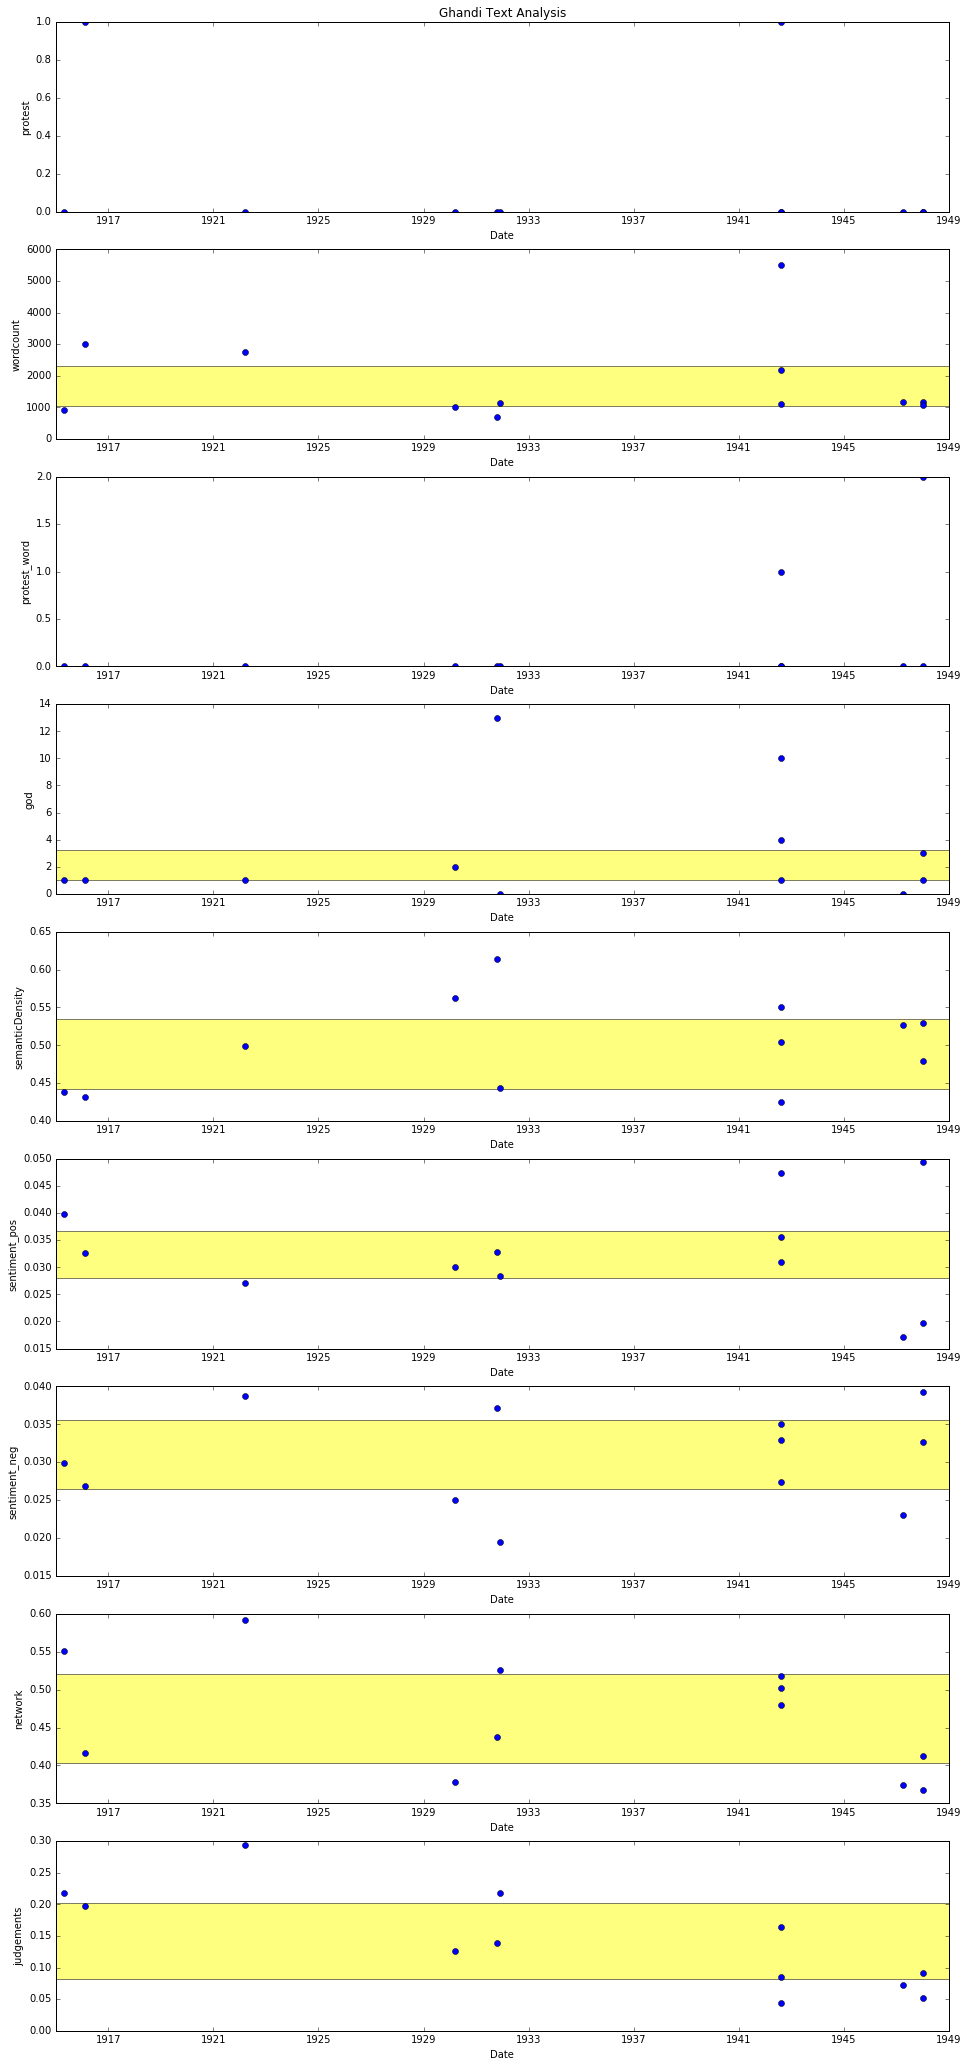

In [505]:
drawSignalPlots(fileData,plotstart,plotend,plotfilename,saveplot )

In [506]:
os.system('say "your program has finished"')

0